# AMZN GOOG Forecasting

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import random
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore") 

In [3]:
# Load dataset 
data = yf.download('AMZN', start='2015-02-08', end='2025-02-08')
data = data[['Close']].dropna()
data.index = pd.to_datetime(data.index)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
# Check for missing values
print(data.isnull().sum())

Price  Ticker
Close  AMZN      0
dtype: int64


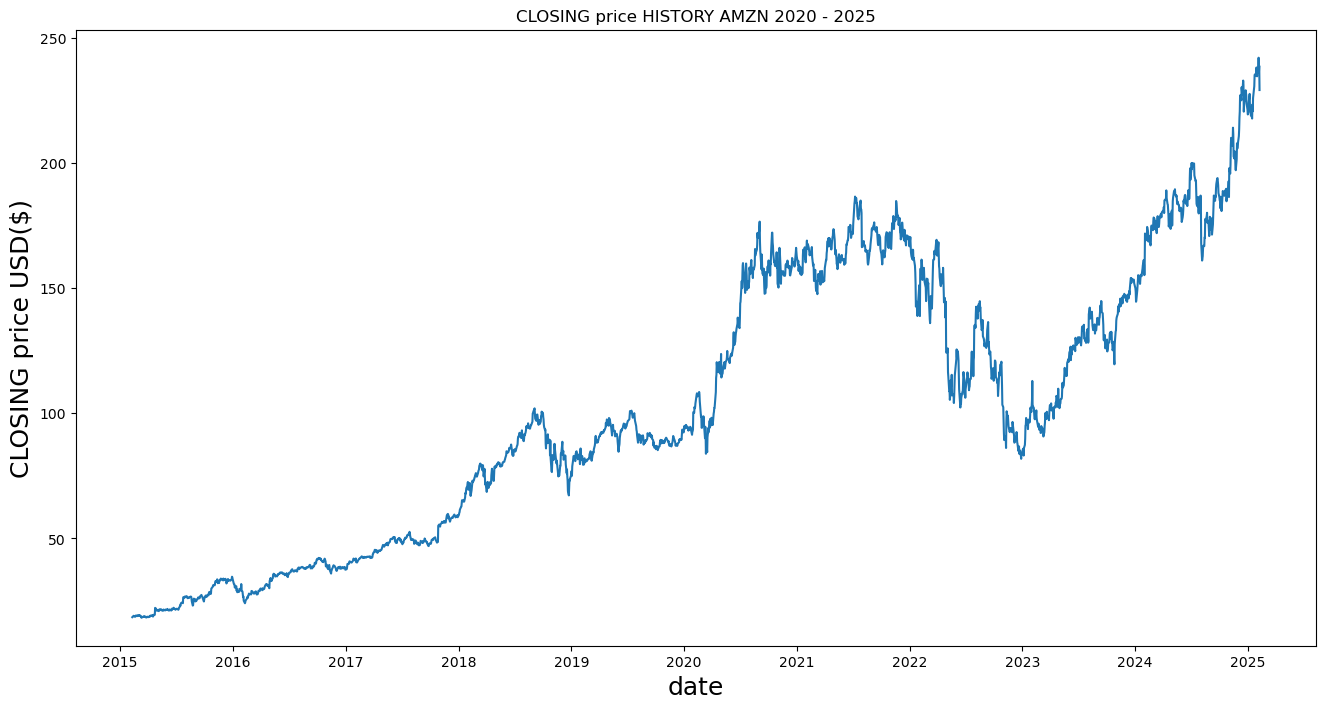

In [5]:
plt.figure(figsize=(16,8))
plt.title('CLOSING price HISTORY AMZN 2020 - 2025')
plt.plot(data['Close'])
plt.xlabel('date',fontsize=18)
plt.ylabel('CLOSING price USD($)',fontsize=18)
plt.show()

## Check close price data for stationarity

## ADF test

In [8]:
def stationarity(col):
    res = adfuller(col.dropna())
    print("Test Statistic:", res[0])
    print("P-Value:", res[1])
    if res[1] < 0.05:
        print("Stationary")
    else:
        print("Non-Stationary")

Test Statistic: -0.08805680202760943
P-Value: 0.9506152053707214
Non-Stationary


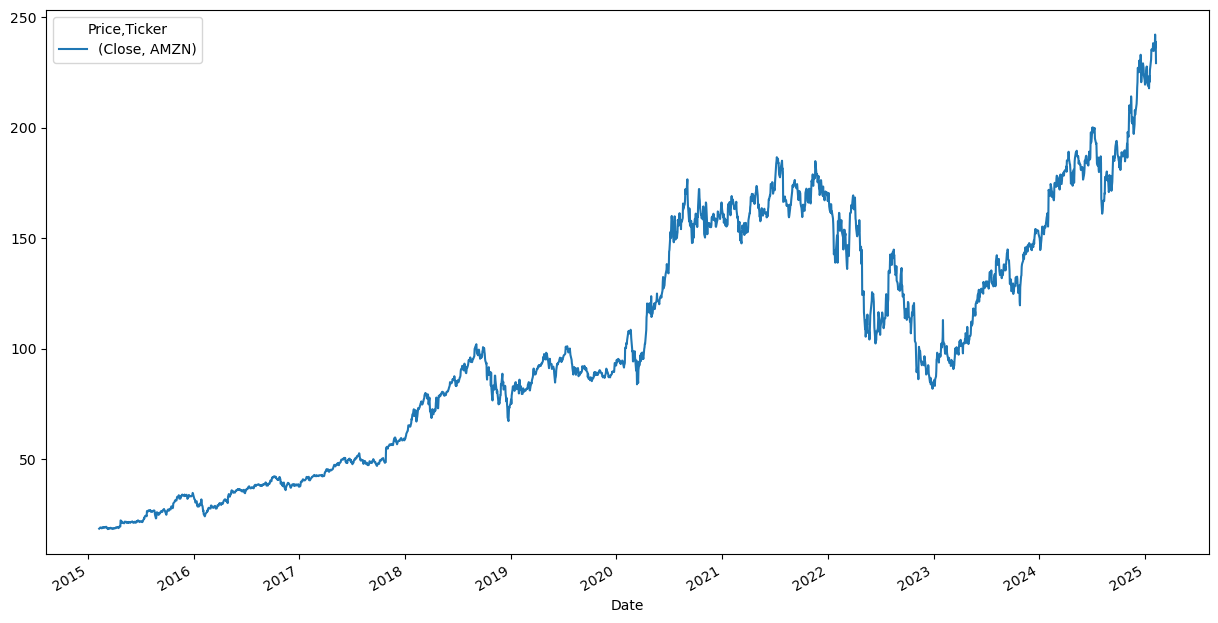

In [9]:
data.plot(figsize=(15,8))

stationarity(data)

### Differencing

Test Statistic: -10.45258453971276
P-Value: 1.4254916834072954e-18
Stationary


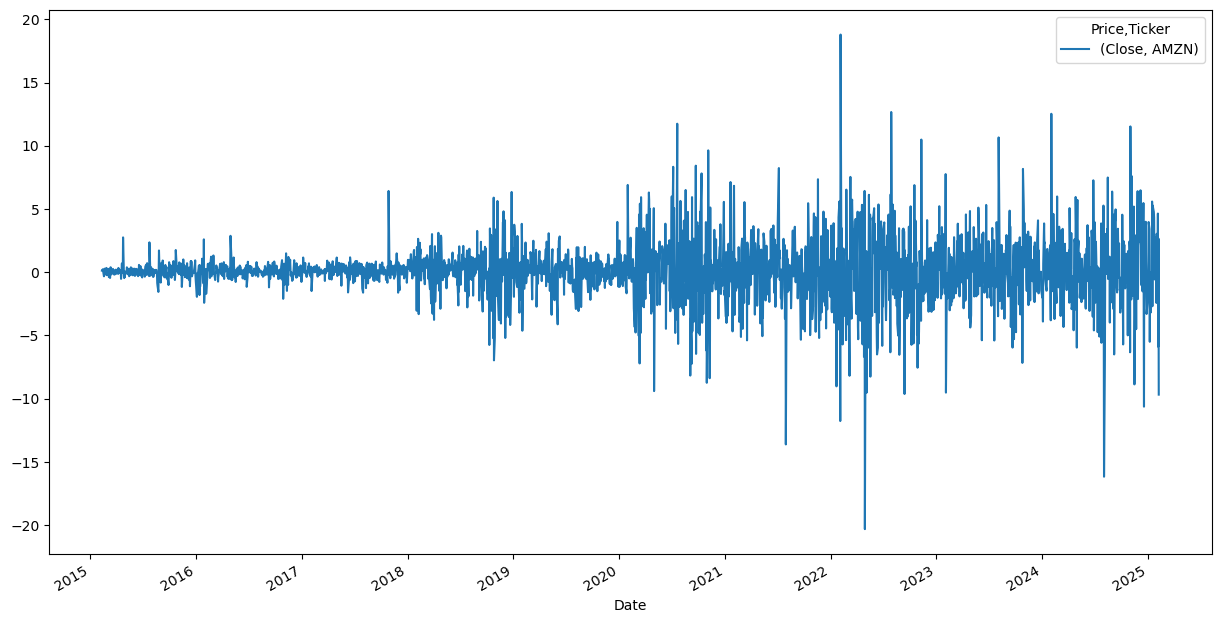

In [11]:
diff_close = data.diff().dropna()
diff_close.plot(figsize=(15,8))

stationarity(diff_close)

We get that the d is 1

### PACF and ACF Test to get the p and q

In [14]:
def pacf(col):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
    ax1.plot(col)
    ax1.set_title('The Column Diff')
    plot_pacf(col, method='ywm', ax=ax2);

def acf(col):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
    ax1.plot(col)
    ax1.set_title('The Column Diff')
    plot_acf(col, ax=ax2);

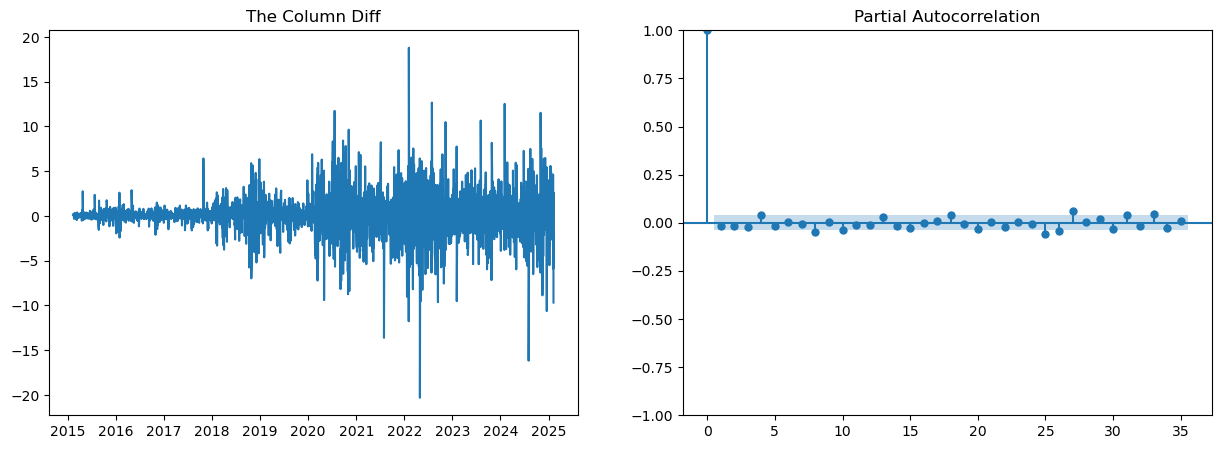

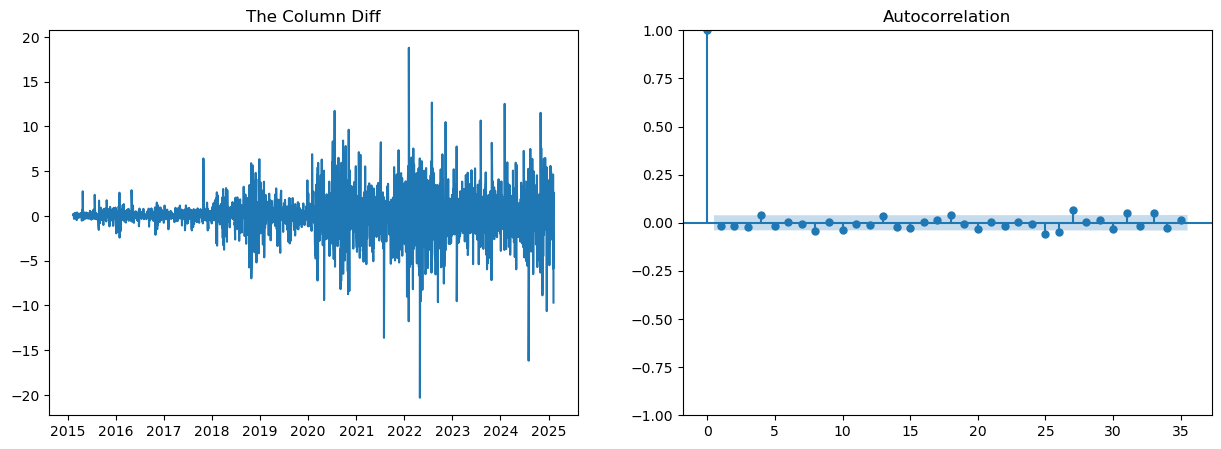

In [15]:
pacf(diff_close)
acf(diff_close)

We get that the p is 0 and q is 0

### ARIMA Model Training

In [18]:
def arima_train_and_plot(data, col_name, p, d, q):
    # 80/20 train-test split
    Test = int(len(data) * 0.2)
    train = data.iloc[:-Test]
    test = data.iloc[-Test:]
    
    # Fit ARIMA model
    arima = ARIMA(train[col_name], order=(p, d, q))
    arima_res = arima.fit()
    
    # Plot actual values
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.plot(data[col_name], label='Actual')
    
    # Plot fitted
    train_pred = arima_res.fittedvalues
    ax.plot(train.index, train_pred, color='green', label='Fitted')
    
    # Forecast
    prediction_res = arima_res.get_forecast(Test)
    forecast = prediction_res.predicted_mean
    conf_int = prediction_res.conf_int()
    lower, upper = conf_int.iloc[:, 0], conf_int.iloc[:, 1]
    ax.plot(test.index, forecast, label='Forecast')
    ax.fill_between(test.index, lower, upper, color='red', alpha=0.3)
    ax.legend()
    
    # Evaluation
    y_true = test[col_name].values
    y_pred = forecast.values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    return rmse, r2

Root Mean Squared Error: 69.0605629307237
R² Score: -2.3547194580132995


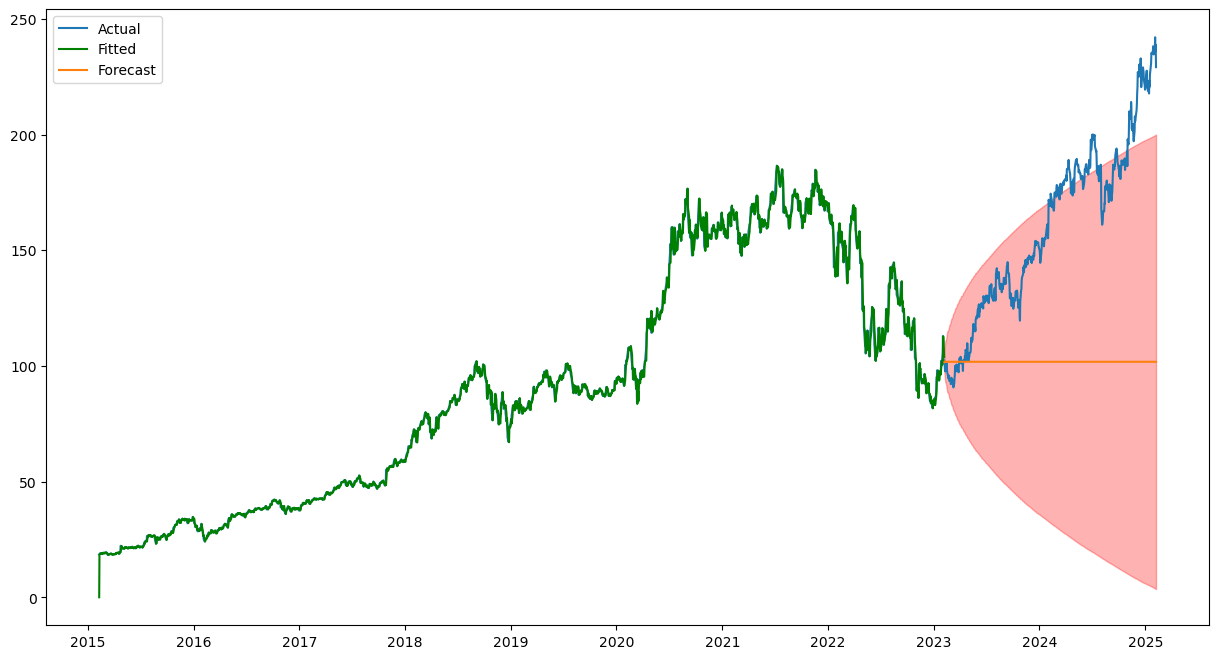

In [19]:
rmse, r2 = arima_train_and_plot(data, 'Close', p=1, d=1, q=2)
print('Root Mean Squared Error:', rmse)
print('R² Score:', r2)

### Data Splitting

In [21]:
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]
train_idx = data.index <= train.index[-1]
test_idx = data.index > train.index[-1]

### Hyperparameter Tuning

In [23]:
# Random search range
p_range = range(0, 5)
d_range = range(0, 3)  
q_range = range(0, 5)
n_iter = 50

best_score = float('inf')
best_order = None
best_model = None

y_train = train['Close']
y_test = test['Close']

for _ in range(n_iter):
    p = random.choice(p_range)
    d = random.choice(d_range)
    q = random.choice(q_range)

    try:
        model = ARIMA(y_train, order=(p, d, q))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(y_test))
        rmse = np.sqrt(mean_squared_error(y_test, forecast))

        if rmse < best_score:
            best_score = rmse
            best_order = (p, d, q)
            best_model = model_fit
    except:
        continue

# Final evaluation
forecast = best_model.forecast(steps=len(y_test))
r2 = r2_score(y_test, forecast)

print(f"Best ARIMA Order (p,d,q): {best_order}")
print(f"RMSE: {best_score:.4f}")
print(f"R² Score: {r2:.4f}")

Best ARIMA Order (p,d,q): (4, 2, 3)
RMSE: 55.3537
R² Score: -1.1496


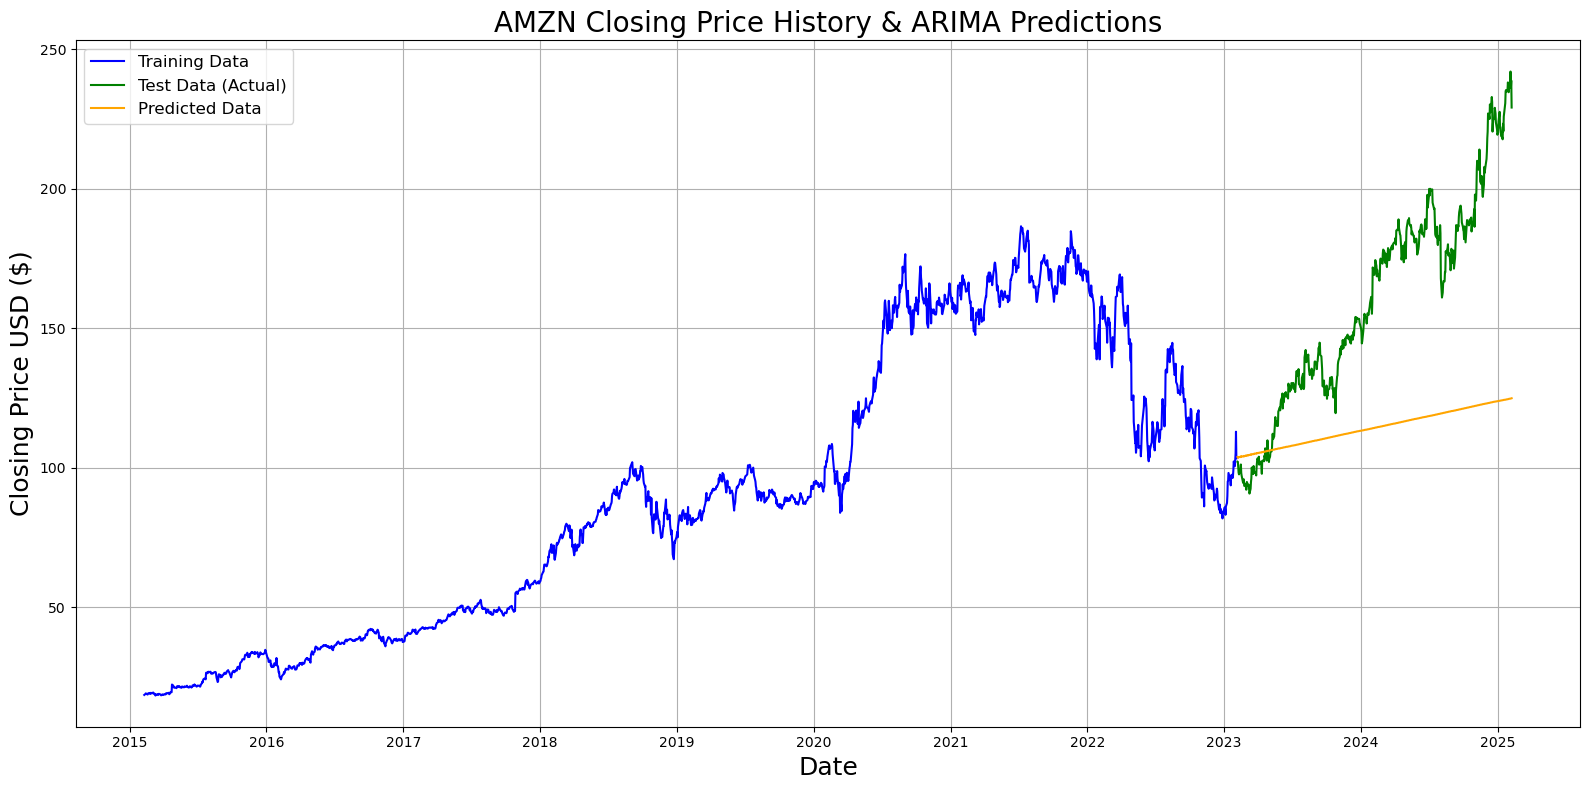

In [24]:
# Plot Forecast vs Actual
plt.figure(figsize=(16, 8))
plt.plot(data.index[:train_size], train, label='Training Data', color='blue')
plt.plot(data.index[train_size:], test, label='Test Data (Actual)', color='green')
plt.plot(data.index[train_size:], forecast, label='Predicted Data', color='orange')
plt.title('AMZN Closing Price History & ARIMA Predictions', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()